### Are some of the same neurons selective for RPE and Features?
One way to look at this would be to compare feature and RPE decoder weights

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import utils.spike_utils as spike_utils
import utils.classifier_utils as classifier_utils
import utils.visualization_utils as visualization_utils

import os
import pandas as pd
import matplotlib

PRE_INTERVAL = 1300
POST_INTERVAL = 1500
INTERVAL_SIZE = 100
EVENT = "FeedbackOnset"

# output dir that was specified in the decode_features_with_pseudo.py
OUTPUT_DIR = "/data/patrick_scratch/pseudo"

SESSIONS_PATH = "/data/patrick_scratch/multi_sess/valid_sessions_rpe.pickle"

FEATURE_DIMS = ["Color", "Shape", "Pattern"]

In [2]:
valid_sess = pd.read_pickle(SESSIONS_PATH)
positions = spike_utils.get_unit_positions(valid_sess)
positions = positions[positions.manual_structure != "unknown"]

Text(0, 0.5, 'Decoder Accuracy')

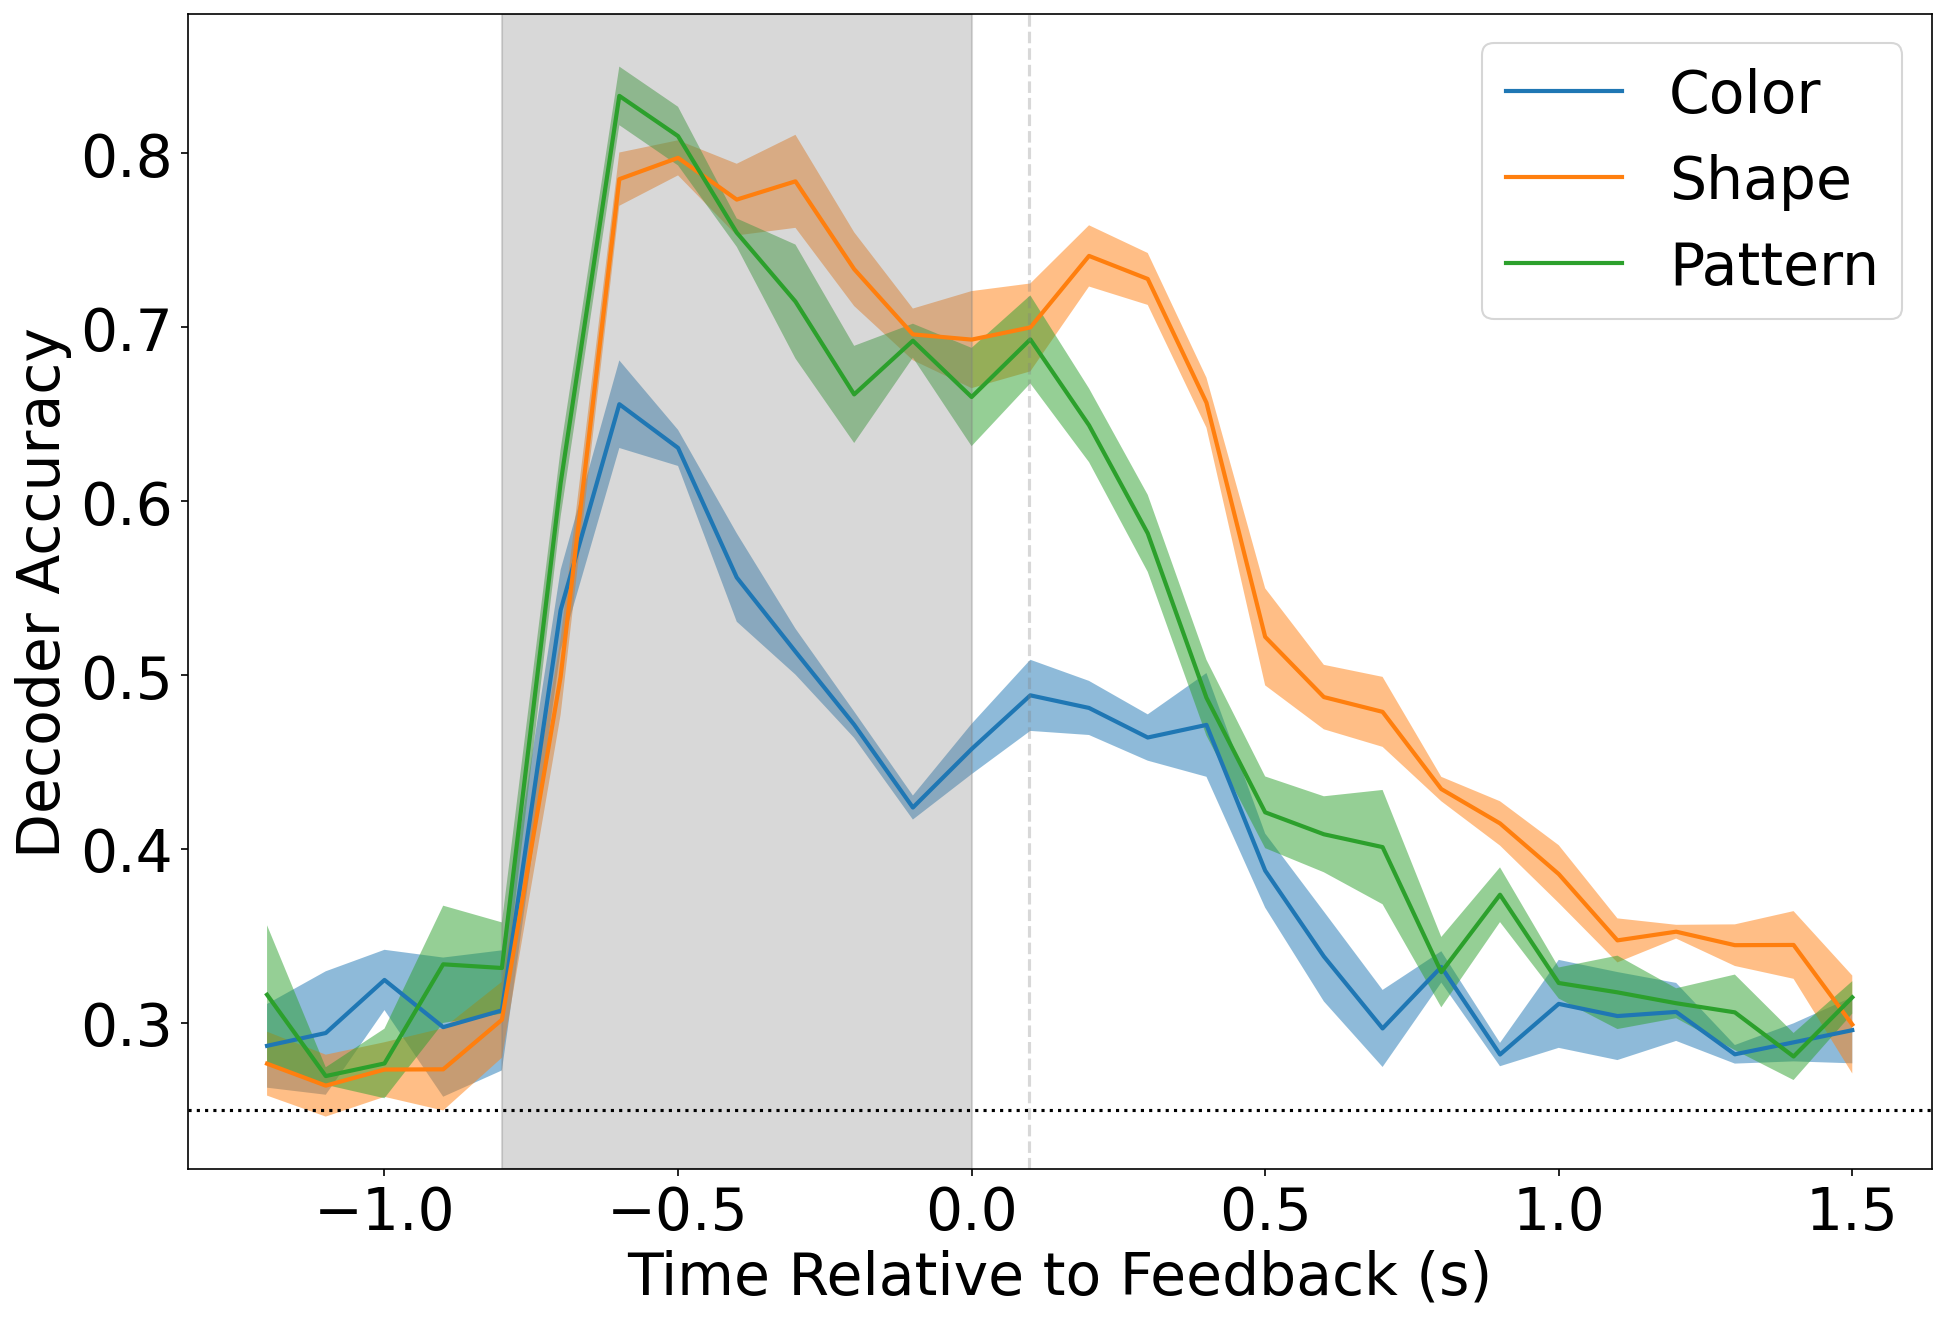

In [3]:
matplotlib.rcParams.update({'font.size': 28})
fig, ax = plt.subplots(dpi=150, figsize=(15, 10))
for feature_dim in FEATURE_DIMS:
    # load the test accuracy of generated from the decode_features_with_pseudo.py script
    # here I'm just visualizing test accuracy, but can very well visualize train/shuffled as well. 
    test_accs = np.load(os.path.join(OUTPUT_DIR, f"{feature_dim}_rpe_sess_test_accs.npy"))
    # plots the mean and standard deviation of decoding accuracy across splits, by time. 
    visualization_utils.visualize_accuracy_across_time_bins(
        test_accs,
        PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
        ax,
        label=f"{feature_dim}",
        right_align=True, 
    )
ax.legend()
# add grey band for selection period
ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
# add dotted line for feedback start
ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
# add estimated chance
ax.axhline(0.25, color='black', linestyle='dotted', label="Estimated Chance")
ax.set_xlabel("Time Relative to Feedback (s)")
ax.set_ylabel("Decoder Accuracy")

In [4]:
all_weights = []
for i, feature_dim in enumerate(FEATURE_DIMS):
    models = np.load(os.path.join(OUTPUT_DIR, f"{feature_dim}_rpe_sess_models.npy"), allow_pickle=True)
    # evaluate weights by time. Pass in number of neurons and number of classes
    weights = classifier_utils.evaluate_model_weights_by_time_bins(models, num_neurons=634, num_classes=4)
    all_weights.append(weights)
all_weights = np.sum(all_weights, axis=0)
normalized = all_weights / np.sum(all_weights, axis=0)
means = np.mean(normalized, axis=1)
means_df = pd.DataFrame({'np_idx': np.arange(len(means)), 'weight': means})

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [28]:
rpe_models = np.load(os.path.join(OUTPUT_DIR, f"rpe_groups_models.npy"), allow_pickle=True)
num_neurons = rpe_models[0, 0].coef_.shape[1]
# evaluate weights by time. Pass in number of neurons and number of classes
rpe_weights = classifier_utils.evaluate_model_weights_by_time_bins(rpe_models, num_neurons=num_neurons, num_classes=4)
norm_rpe_weights = rpe_weights / np.sum(rpe_weights, axis=0)

Text(0.5, 1.0, 'RPE Group weights')

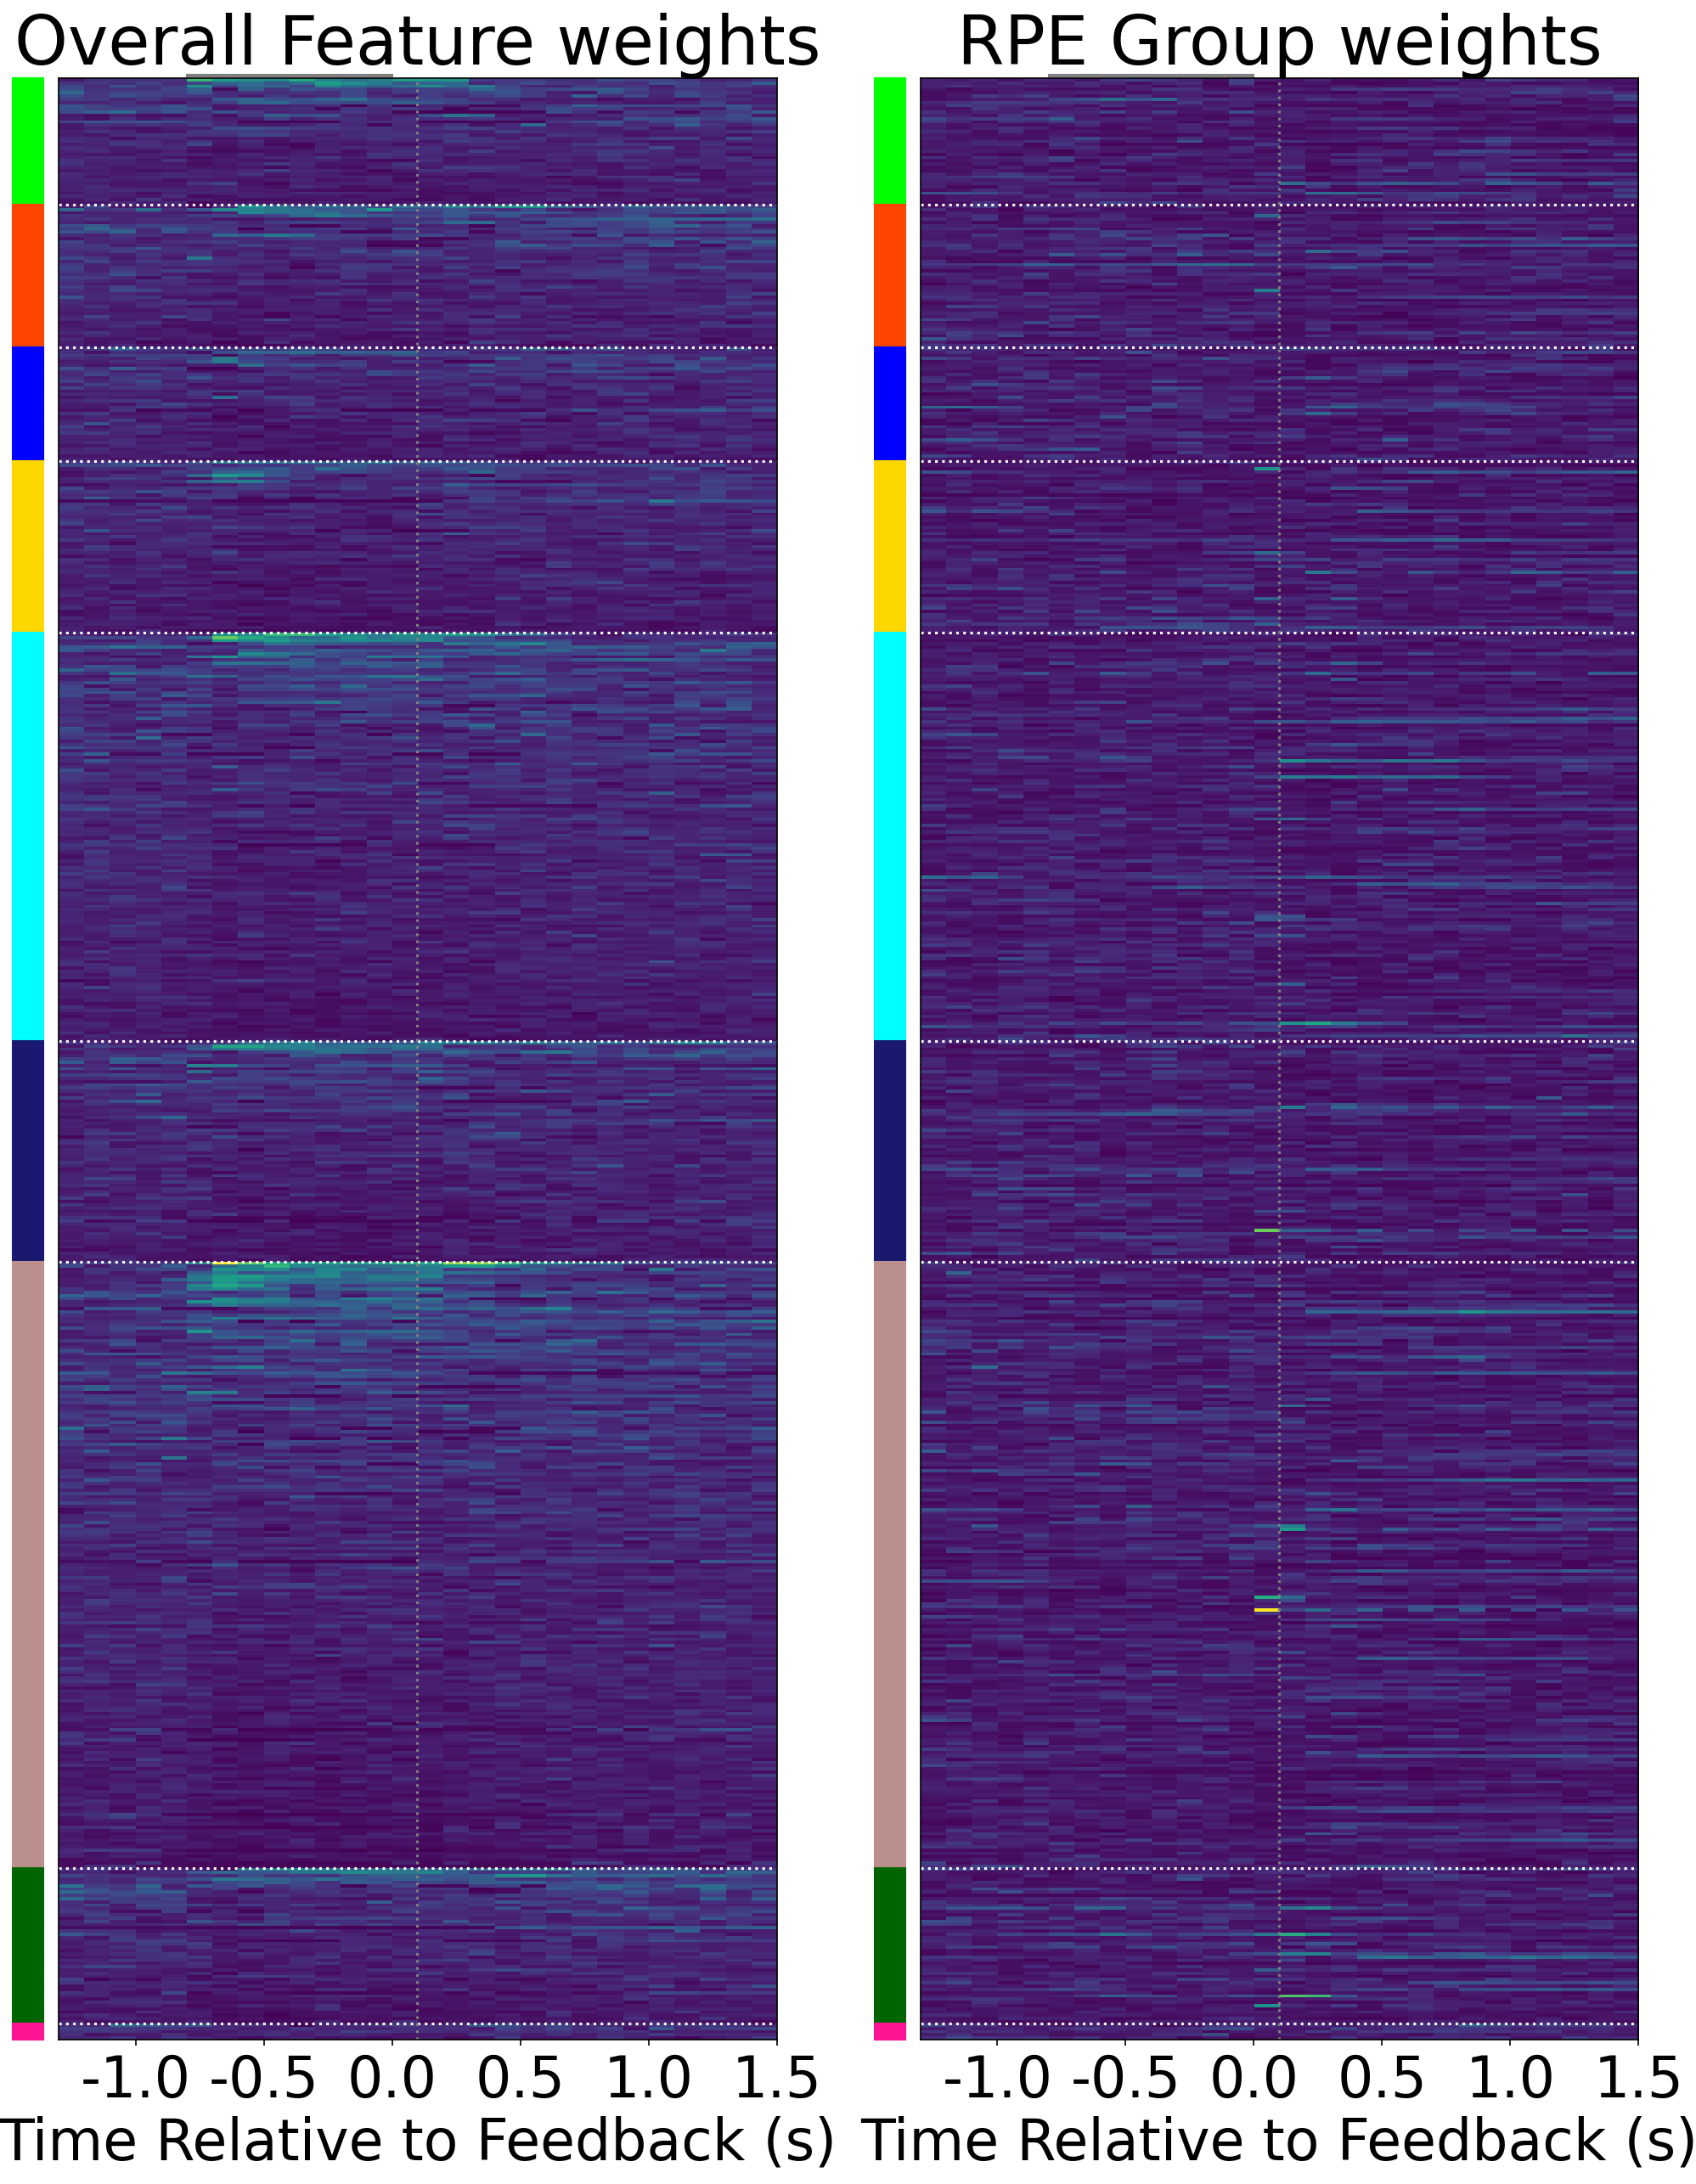

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(16, 20), dpi=150, sharex=True)
matplotlib.rcParams.update({'font.size': 32})
visualization_utils.visualize_weights(
    positions, 
    normalized, 
    "manual_structure", 
    name_to_color=visualization_utils.REGION_TO_COLOR, 
    add_region=True, 
    mean_weights_df=means_df,
    ax=axs[0]
)
axs[0].set_title("Overall Feature weights")
visualization_utils.visualize_weights(
    positions, 
    norm_rpe_weights, 
    "manual_structure", 
    name_to_color=visualization_utils.REGION_TO_COLOR, 
    add_region=True, 
    mean_weights_df=None,
    ax=axs[1]
)
axs[1].set_title("RPE Group weights")

